In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!ls "gdrive/MyDrive/7th Sem Project"

maps.npz  Models  Plots


In [3]:
from numpy import load
import matplotlib.pyplot as plt

In [4]:
data = load("gdrive/MyDrive/7th Sem Project/maps.npz")
print(data.files)

['arr_0', 'arr_1']


In [5]:
src_images, tar_images = data['arr_0'], data['arr_1']
print("Source(Satellite) Shape :", src_images.shape, "\nTarget(Google Map) Shape:", tar_images.shape)

Source(Satellite) Shape : (1096, 256, 256, 3) 
Target(Google Map) Shape: (1096, 256, 256, 3)


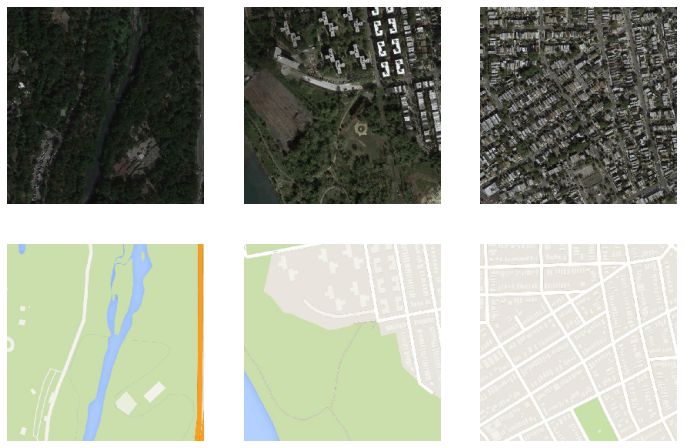

In [6]:
plt.figure(figsize=(12,8))
for i in range(3):
  plt.subplot(2, 3, i+1)
  plt.axis("off")
  plt.imshow(src_images[i])
for i in range(3):
  plt.subplot(2, 3, i+1+3)
  plt.axis("off")
  plt.imshow(tar_images[i])
plt.show()

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Concatenate, Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

In [8]:
def define_discriminator(image_shape=(256, 256, 3)):
  init = RandomNormal(stddev=0.02)

  in_src_image = Input(shape=image_shape)
  in_target_image = Input(shape=image_shape)

  merged = Concatenate()([in_src_image, in_target_image])

  d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d)
  patch_out = Activation("sigmoid")(d)

  model = Model([in_src_image, in_target_image], patch_out)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, loss_weights=[0.5])

  return model

In [9]:
discriminator = define_discriminator()
discriminator.summary(),

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]     

(None,)

In [10]:
from tensorflow.keras.utils import plot_model

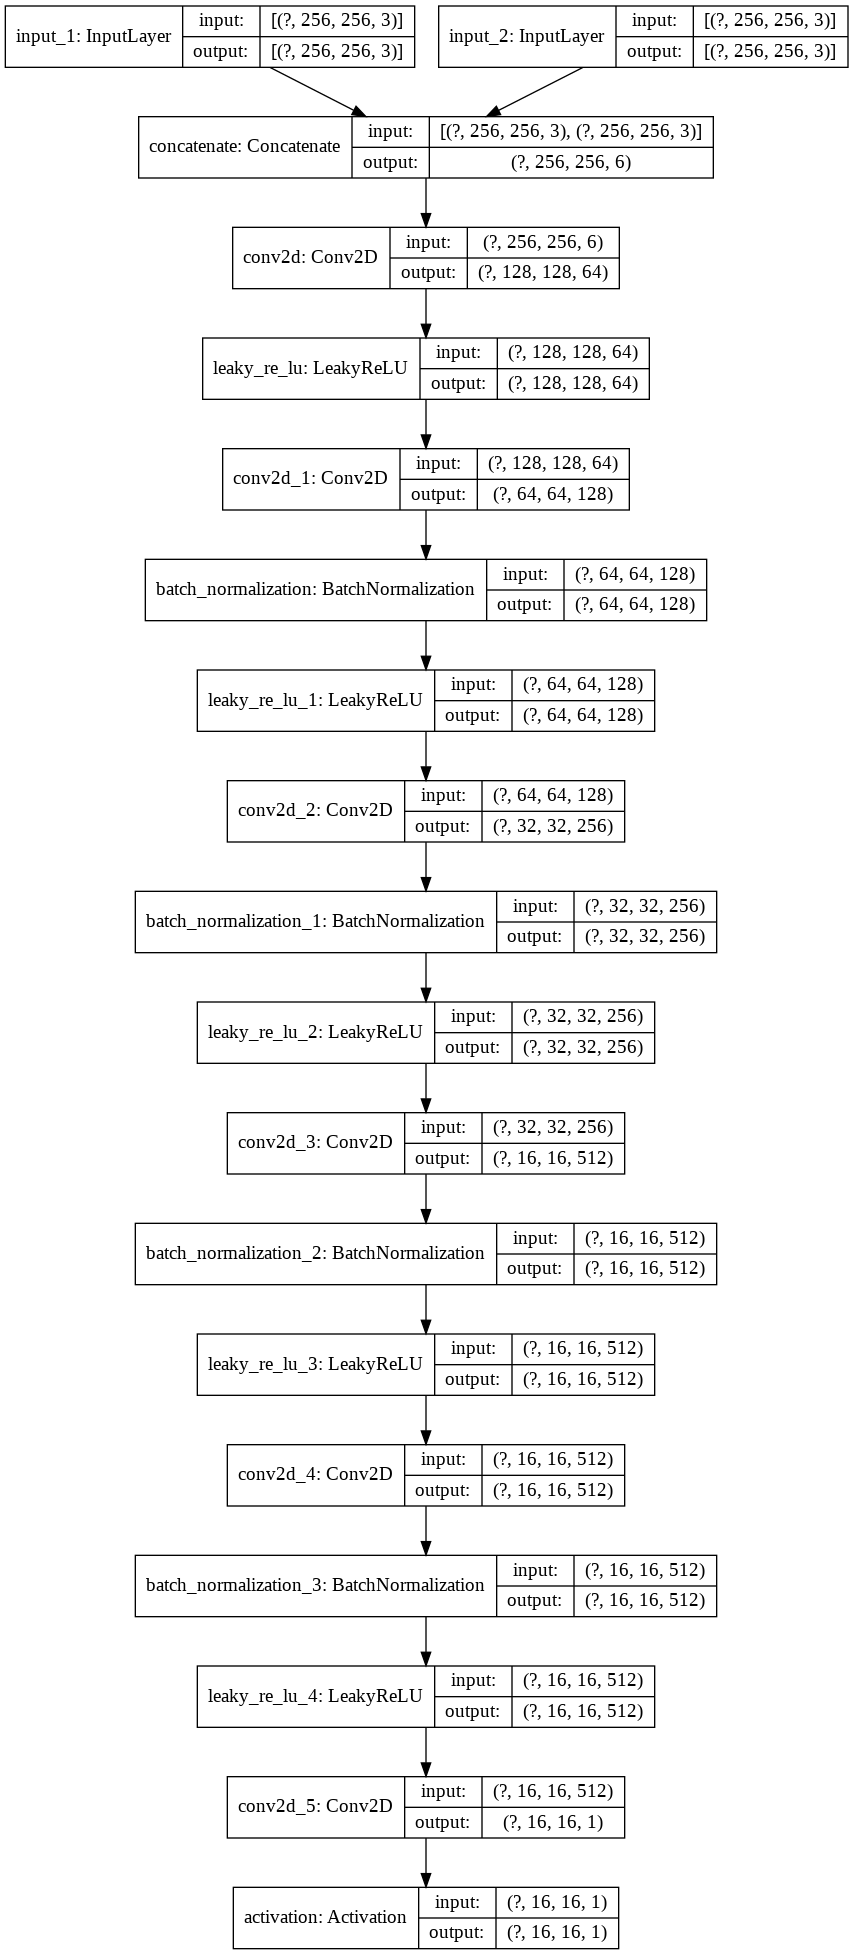

In [11]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [12]:
from tensorflow.keras.layers import Conv2DTranspose, Dropout

In [13]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  init = RandomNormal(stddev=0.02)
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)
  return g

In [14]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  init = RandomNormal(stddev=0.02)
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g, training=True)
  if dropout:
    g = Dropout(0.5)(g, training=True)
  g = Concatenate()([g, skip_in])
  g = Activation("relu")(g)
  return g

In [15]:
def define_generator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)

  b = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(e7)
  b = Activation("relu")(b)

  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d7)
  out_image = Activation("tanh")(g)

  model = Model(in_image, out_image)
  return model

In [16]:
generator = define_generator()
generator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
_______________________________________________________________________________________

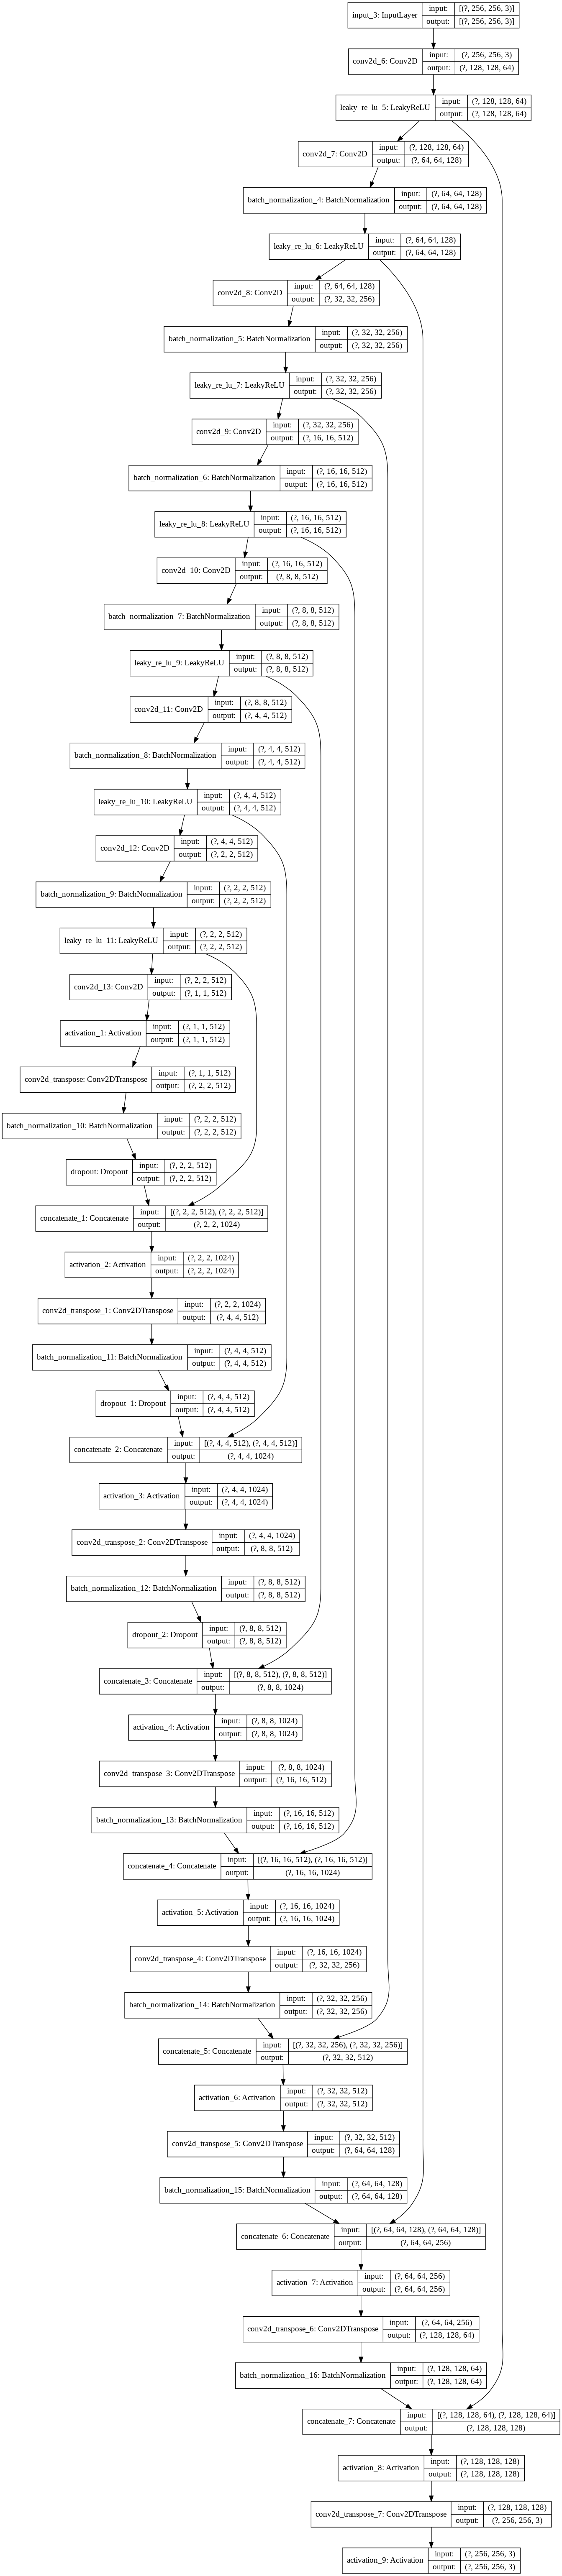

In [17]:
plot_model(generator, show_layer_names=True, show_shapes=True)

In [18]:
def define_gan(g_model, d_model, image_shape):
  d_model.trainable = False
  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  dis_out = d_model([in_src, gen_out])
  model = Model(in_src, [dis_out, gen_out])
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=["binary_crossentropy", "mae"], optimizer=opt, loss_weights=[1,100])
  return model

In [19]:
gan = define_gan(generator, discriminator, (256, 256, 3))
gan.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 functional_3[0][0]               
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


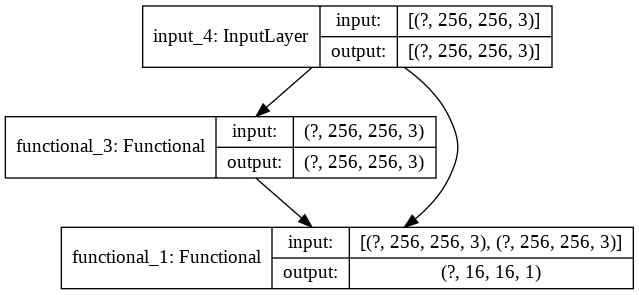

In [20]:
plot_model(gan, show_layer_names=True, show_shapes=True)

In [21]:
src_images = src_images.astype('float32')
tar_images = tar_images.astype('float32')

In [22]:
src_images = (src_images - 127.5)/127.5
tar_images = (tar_images -127.5)/127.5

In [23]:
dataset = [src_images, tar_images]

In [24]:
from numpy import ones, zeros
from numpy.random import randint, randn

In [25]:
def generate_real_samples(n, patch_shape):
  ix = randint(0, src_images.shape[0], n)
  X1 = src_images[ix]
  X2 = tar_images[ix]
  y = ones((n, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [26]:
def generate_fake_smaples(generator, samples, patch_shape):
  X = generator.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [27]:
!mkdir "Plots"
!mkdir "Models"
!ls

gdrive	model.png  Models  Plots  sample_data


In [28]:
def summarize_performance(step, generator, n=3):
  [X_realA, X_realB], _ = generate_real_samples(n, 1)
  X_fakeB, _ = generate_fake_smaples(generator, X_realA, 1)
  X_realA = (X_realA+1)/2
  X_realB = (X_realB+1)/2
  X_fakeB = (X_fakeB+1)/2

  plt.figure(figsize=(12,8))
  for i in range(n):
    plt.subplot(3, n, 1+i)
    plt.axis("off")
    plt.imshow(X_realA[i])
    
  for i in range(n):
    plt.subplot(3, n, 1+n+i)
    plt.axis("off")
    plt.imshow(X_fakeB[i])
    
  for i in range(n):
    plt.subplot(3, n, 1+2*n+i)
    plt.axis("off")
    plt.imshow(X_realB[i])

  plt.savefig("gdrive/MyDrive/7th Sem Project/Plots/plot_%06d.png"%(step+1))
  generator.save("gdrive/MyDrive/7th Sem Project/Models/model_%06d.h5"%(step+1))
  print("Saved image and plot for step:", step+1)

In [33]:
def train(discriminator, generator, gan, epochs=100, batch=1):
  n_patch = discriminator.output_shape[1]
  trainA, trainB = dataset
  bat_per_epo = len(trainA)//batch
  steps = bat_per_epo*epochs
  summarize_performance(-1, generator)
  print("Model will be saved after every",bat_per_epo*10, "steps, i.e after every 10 epochs")
  for i in range(steps):
    [X_realA, X_realB], y_real = generate_real_samples(batch, n_patch)
    X_fakeB, y_fake = generate_fake_smaples(generator, X_realA, n_patch)
    d_loss1 = discriminator.train_on_batch([X_realA, X_realB], y_real)
    d_loss2 = discriminator.train_on_batch([X_realA, X_fakeB], y_fake)
    gan_loss, _, _ = gan.train_on_batch(X_realA, [y_real, X_realB])
    if i%bat_per_epo == 0:
      print("Epoch: %3d/100, d1[%0.3f] d2[%0.3f] g[%0.3f]"%((i)//bat_per_epo, d_loss1, d_loss2, gan_loss))
    if (i+1)%(bat_per_epo*10) == 0:
      summarize_performance(i, generator)

In [30]:
image_shape = dataset[0].shape[1:]
print(image_shape)

(256, 256, 3)


In [31]:
discriminator = define_discriminator(image_shape)
generator = define_generator(image_shape)
gan = define_gan(generator, discriminator, image_shape)

Saved image and plot for step: 0
Model will be saved after every 10960 steps, i.e after every 10 epochs
Epoch:   0/100, d1[0.255] d2[0.600] g[66.373]
Epoch:   1/100, d1[0.004] d2[0.002] g[7.188]
Epoch:   2/100, d1[0.000] d2[0.001] g[9.543]
Epoch:   3/100, d1[0.000] d2[0.000] g[7.337]
Epoch:   4/100, d1[0.001] d2[0.000] g[7.288]
Epoch:   5/100, d1[0.000] d2[0.000] g[11.804]
Epoch:   6/100, d1[0.000] d2[0.000] g[6.607]
Epoch:   7/100, d1[0.000] d2[0.000] g[8.968]
Epoch:   8/100, d1[0.000] d2[0.000] g[2.931]
Epoch:   9/100, d1[0.000] d2[0.000] g[6.214]
Saved image and plot for step: 10960
Epoch:  10/100, d1[0.000] d2[0.000] g[6.373]
Epoch:  11/100, d1[0.000] d2[0.000] g[5.943]
Epoch:  12/100, d1[0.000] d2[0.000] g[6.067]
Epoch:  13/100, d1[0.000] d2[0.000] g[5.245]
Epoch:  14/100, d1[0.000] d2[0.000] g[7.223]
Epoch:  15/100, d1[0.000] d2[0.000] g[5.207]
Epoch:  16/100, d1[0.000] d2[0.002] g[7.841]
Epoch:  17/100, d1[0.000] d2[0.000] g[4.283]
Epoch:  18/100, d1[0.000] d2[0.000] g[5.818]
Ep

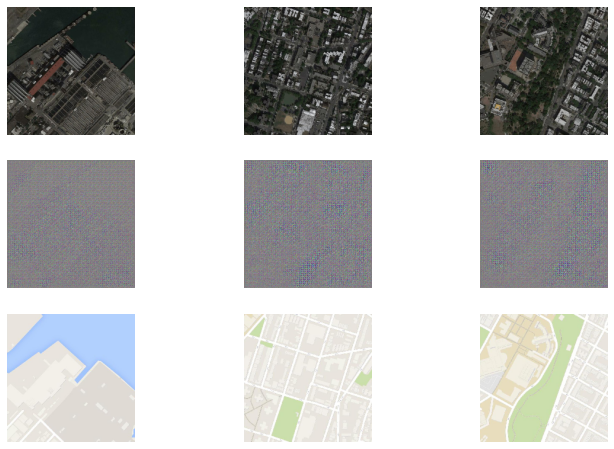

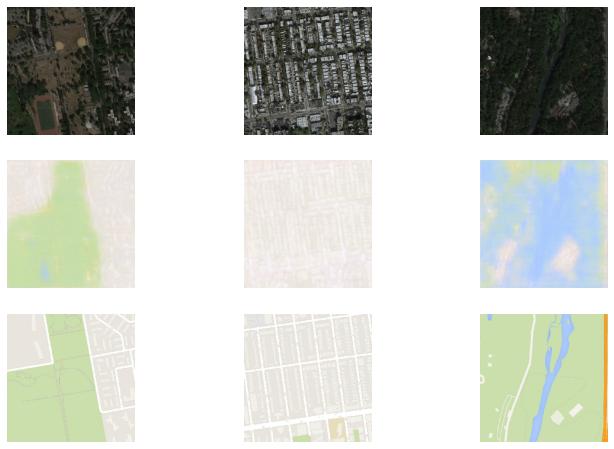

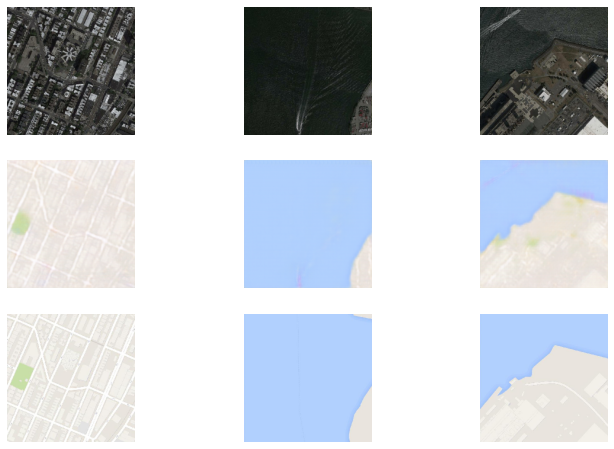

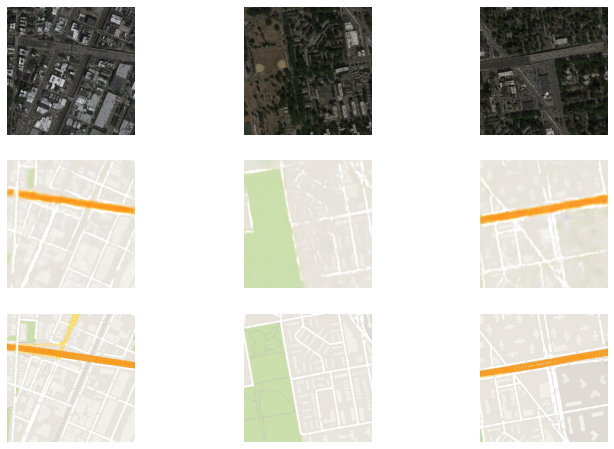

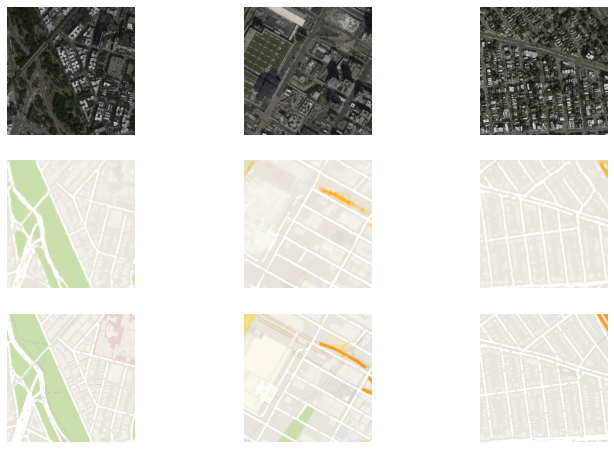

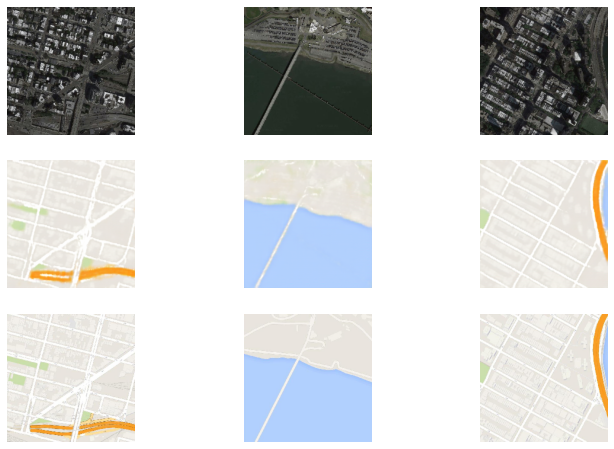

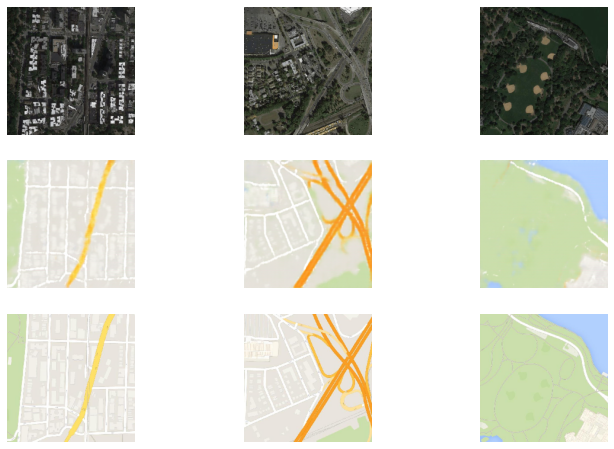

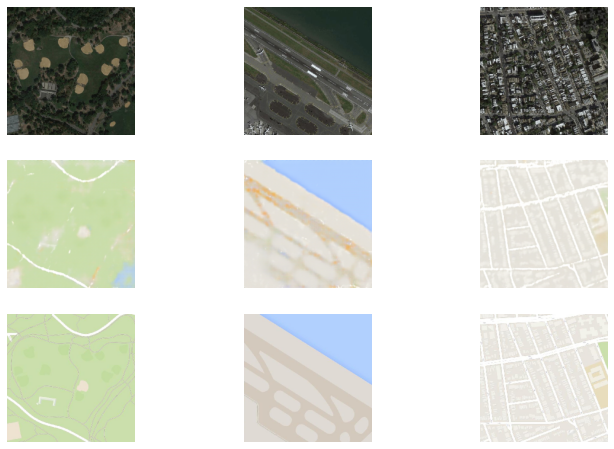

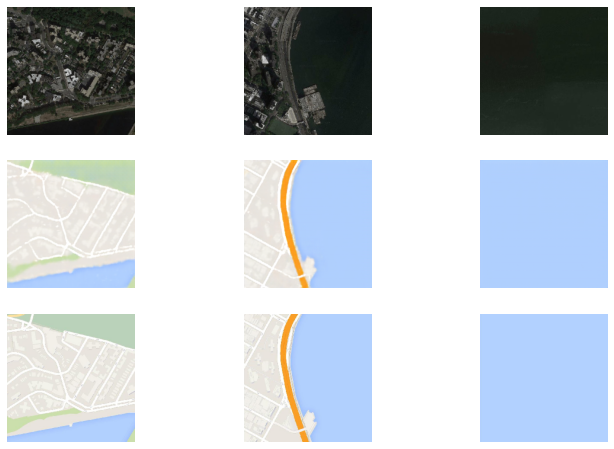

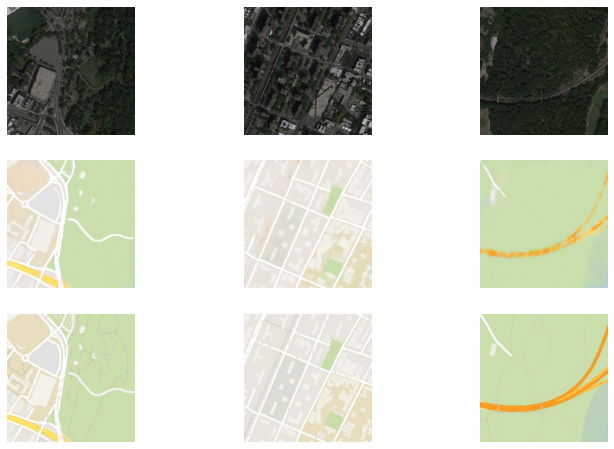

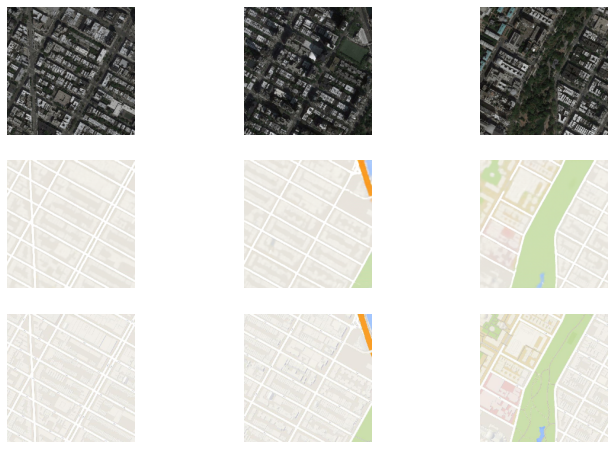

In [34]:
train(discriminator, generator, gan)